In [109]:
import numpy as np
import pandas as pd

import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation

import matplotlib.pyplot as plt

import time
from datetime import datetime

import tba3102

In [110]:
tba3102.set_default_pandas_options(max_columns=11)

np.random.seed(int(round(time.time())))

In [111]:
def average_word_vectors(words, model, vocabulary, num_features):

    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        
        if word in vocabulary:
            
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        
        feature_vector = np.divide(feature_vector, nwords)
    
    return feature_vector



def averaged_word_vectorizer(corpus, model, num_features):

    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) 
        for tokenized_sentence in corpus]
    
    return np.array(features)

In [112]:
file_name = "cleaned-galaxy"
# file_name = "cleaned-apple_review"
# file_name = "cleaned-samsung_vs_pixel"
df = pd.read_csv(f'../data/{file_name}.csv')
# random_state = np.random.randint(2**31-1)
# random_state = 945649140
# print('random_state: {}'.format(random_state))
df.head()

,Comment ID,Comment Body,Author,Upvotes,Timestamp,Cleaned_Comment
0,m5u0cnr,"""Presenting, the new s25 series, now with the ...",EVD27,213,1.736231e+09,present new series new gap camera bump well di...
1,m5ttncm,"More like s24 ultra rounded version, given the...",Miyukicc,67,1.736227e+09,like ultra rounded version give minimal speck ...
2,m5tix2l,Same phone in a slightly new body (ultra) \n\n...,judgedavid90,397,1.736223e+09,phone slightly new body ultra give I shit chip...
3,m5tahhm,"Looks great, now only if they would fix their ...",One-Patience-1187,83,1.736220e+09,look great would fix camera oversaturate overe...
4,m5tut4z,The trade in deals better be out of this world,UrDoinGood2,24,1.736228e+09,trade deal well world


In [113]:
# df = df.sample(frac=0.50, replace=False, random_state=random_state)
# df.reset_index(inplace=True)

print('Text processing started at {}'.format(datetime.now()))

Text processing started at 2025-04-08 02:31:15.489799


In [114]:
tba3102.data_quality_report(df)

,Comment ID,Comment Body,Author,Upvotes,Timestamp,Cleaned_Comment
count,484,484,484,484.0,484.0,480
unique,484,484,361,NaN,NaN,479
top,m5u0cnr,"""Presenting, the new s25 series, now with the ...",judgedavid90,NaN,NaN,literally look like
freq,1,1,11,NaN,NaN,2
mean,NaN,NaN,NaN,4.522727,1736414664.892562,NaN
std,NaN,NaN,NaN,21.857185,428993.343511,NaN
min,NaN,NaN,NaN,1.0,1736217359.0,NaN
25%,NaN,NaN,NaN,1.0,1736250955.25,NaN
50%,NaN,NaN,NaN,1.0,1736275795.0,NaN
75%,NaN,NaN,NaN,2.0,1736347898.25,NaN


In [115]:
df['Cleaned_Comment'].replace(r'^(\s)+$', np.nan, regex=True, inplace=True)
df = df.dropna(subset=['Cleaned_Comment']).reset_index(drop=True)

C:\Users\tee_m\AppData\Local\Temp\ipykernel_35332\1582164825.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cleaned_Comment'].replace(r'^(\s)+$', np.nan, regex=True, inplace=True)


In [116]:
# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in df['Cleaned_Comment']]
tokenized_corpus

[['present',
  'new',
  'series',
  'new',
  'gap',
  'camera',
  'bump',
  'well',
  'dirt',
  'collection'],
 ['like',
  'ultra',
  'rounded',
  'version',
  'give',
  'minimal',
  'speck',
  'upgrade'],
 ['phone',
  'slightly',
  'new',
  'body',
  'ultra',
  'give',
  'I',
  'shit',
  'chip',
  'nobody',
  'care',
  'real',
  'world',
  'difference',
  'I',
  'bet',
  'everything',
  'I',
  'higher',
  'number',
  'meaningless',
  'benchmark',
  'equal',
  'reason',
  'buy',
  'new',
  'phone',
  'process',
  'photo',
  'second',
  'fast',
  'care',
  'love',
  'pile',
  'apple',
  'make',
  'phone',
  'year',
  'year',
  'samson',
  'become',
  'guilty',
  'I',
  'believe',
  'I',
  'year',
  'current',
  'phone',
  'u',
  'I',
  'toss',
  'ultra',
  'spend',
  'literally',
  'half',
  'money',
  'u',
  'difference',
  'negligible'],
 ['look',
  'great',
  'would',
  'fix',
  'camera',
  'oversaturate',
  'overexpose',
  'post',
  'process'],
 ['trade', 'deal', 'well', 'world'],
 

In [117]:
# Set values for various parameters
feature_size = 200 # Word vector dimensionality
window_context = 20 # Context window size
min_word_count = 20 # Minimum word count
sample = 1e-3 # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=feature_size, window=window_context, min_count=min_word_count, sample=sample, epochs=100)

c:\Users\tee_m\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


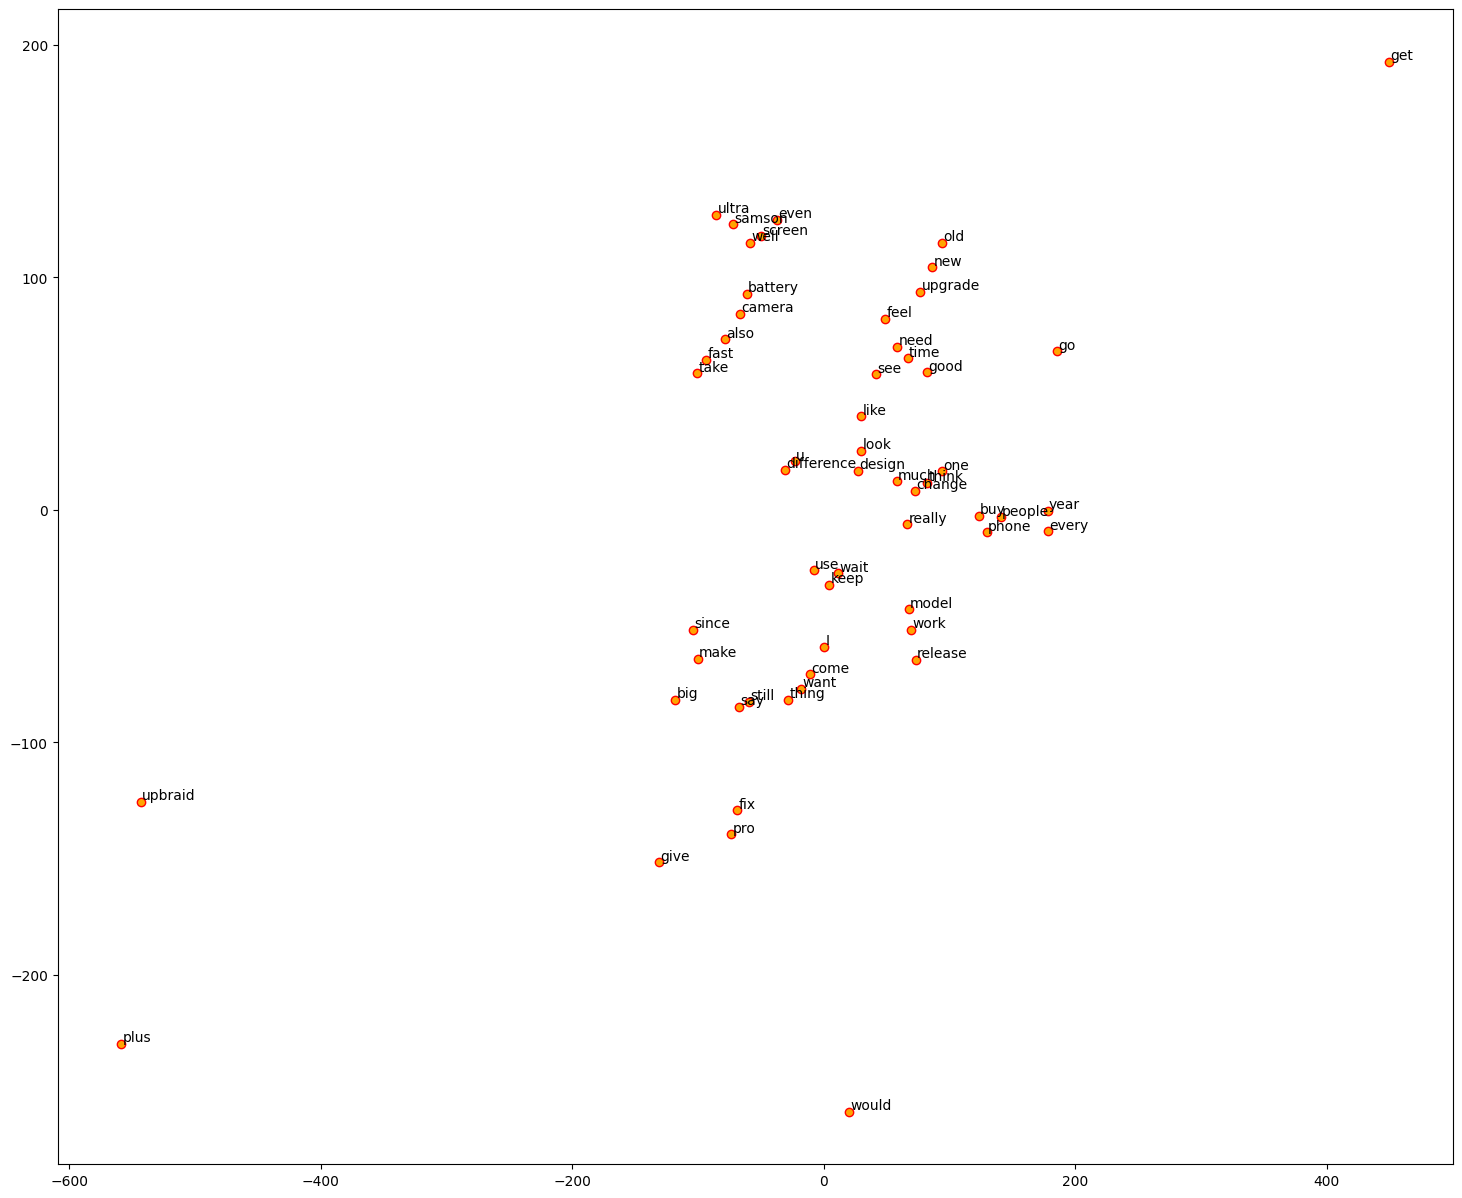

In [118]:
words = w2v_model.wv.index_to_key
wvs = w2v_model.wv[words]
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 15))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')

for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [119]:
# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model, num_features=feature_size)

In [120]:
ap = AffinityPropagation(max_iter=500, damping=0.7, random_state=None)
ap.fit(w2v_feature_array)
cluster_centers_indices = ap.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
df_cluster_word2vec = pd.concat([df, cluster_labels], axis=1)
df_cluster_word2vec.to_csv(f'../data/{file_name}_cluster_word2vec.csv')

print('Estimated number of cluster is {}'.format(n_clusters_))

Estimated number of cluster is 64


In [121]:
print('Text processing ended at {}'.format(datetime.now()))

Text processing ended at 2025-04-08 02:31:17.712492


In [122]:
df_cluster_word2vec.groupby(by="ClusterLabel")["ClusterLabel"].count().sort_values(ascending=False).reset_index(name="count")

,ClusterLabel,count
0,32,51
1,29,37
2,36,31
3,57,27
4,50,27
5,63,25
6,30,24
7,40,23
8,22,21
9,55,20


In [123]:
df_cluster_word2vec.sort_values(by="ClusterLabel")

,Comment ID,Comment Body,Author,Upvotes,Timestamp,Cleaned_Comment,ClusterLabel
163,m6d2j46,more of the same old boring,sheldonxp2000,1,1.736490e+09,old bore,0
7,m5tojn2,same old shit. What does it do that s24u can't?🤔,ghuk123,21,1.736225e+09,old shit,0
14,m5v8azi,The wallpapers are beautiful,UnhappyAd7832,3,1.736256e+09,wallpaper beautiful,1
243,m5vsouy,I'm pretty sure the elite chip is meant to be ...,ImawhaleCR,1,1.736263e+09,I pretty sure elite chip mean fair bit efficie...,2
432,m5vwsy6,"I assume they don't know the offer exists, or ...",MtnXfreeride,1,1.736265e+09,I assume know offer exist want use goose I car...,2
90,m5weoek,I miss when companies actually used to innovate,Original-Sundae287,1,1.736270e+09,I miss company actually use innate,2
180,m6xourd,Is it only me or someone else HATE those round...,FlacFanDAC,1,1.736783e+09,I someone else hate round corner,2
98,m5wzs77,Thank god I'll finally be able to afford an s2...,____nothing__,1,1.736276e+09,thank god I finally able afford,2
15,m5y9a9f,All I want is Qi2 🥺,Fezzicc,3,1.736289e+09,I want I,2
413,m67io1c,"Not me, i raw dog it",Senkajo,1,1.736422e+09,I I raw dog,2
